In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
include("src/spiking.jl")
include("src/vsa.jl")

similarity_outer (generic function with 2 methods)

In [3]:
using Plots

In [4]:
n_x = 101
n_y = 101
n_vsa = 1

1

In [5]:
repeats = 6

6

In [6]:
phases = collect([[x, y] for x in range(-1.0, 1.0, n_x), y in range(-1.0, 1.0, n_y)]) |> stack
phases = reshape(phases, (1,2,:))

1×2×10201 Array{Float64, 3}:
[:, :, 1] =
 -1.0  -1.0

[:, :, 2] =
 -0.98  -1.0

[:, :, 3] =
 -0.96  -1.0

;;; … 

[:, :, 10199] =
 0.96  1.0

[:, :, 10200] =
 0.98  1.0

[:, :, 10201] =
 1.0  1.0

In [7]:
b = bind(phases, dims=2)

1×1×10201 Array{Float64, 3}:
[:, :, 1] =
 0.0

[:, :, 2] =
 0.020000000000000018

[:, :, 3] =
 0.040000000000000036

;;; … 

[:, :, 10199] =
 -0.040000000000000036

[:, :, 10200] =
 -0.020000000000000018

[:, :, 10201] =
 0.0

In [8]:
spk_args = SpikingArgs(t_window=0.01)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [9]:
tspan = (0.0, repeats*1.0)

(0.0, 6.0)

In [10]:
tbase = collect(tspan[1]:spk_args.dt:tspan[2]);

In [11]:
st_x = phase_to_train(phases[1:1,1:1,:], spk_args, repeats = repeats)
st_y = phase_to_train(phases[1:1,2:2,:], spk_args, repeats = repeats)

Spike Train: (1, 1, 10201) with 61206 spikes.

In [12]:
st_x.shape

(1, 1, 10201)

In [13]:
st_x

Spike Train: (1, 1, 10201) with 61206 spikes.

In [68]:
function bind(x::SpikeTrain, y::SpikeTrain; tspan::Tuple{<:Real, <:Real} = (0.0, 10.0), spk_args::SpikingArgs = default_spk_args(), return_solution::Bool = false)
    #set up functions to define the neuron's differential equations
    k = neuron_constant(spk_args)

    #get the number of batches & output neurons
    output_shape = x.shape

    #find the complex state induced by the spikes
    sol_x = phase_memory(x, tspan=tspan, spk_args=spk_args)
    sol_y = phase_memory(y, tspan=tspan, spk_args=spk_args)

    to_array = x -> normalize_potential.(Array(x))
    u_x = to_array(sol_x)
    u_y = to_array(sol_y)

    n_t = length(sol_x.t)
    ref_shape = (ones(Int, length(output_shape))..., n_t)
    #create a reference oscillator to generate complex values for each moment in time
    u_ref = phase_to_potential(0.0, sol_x.t, x.offset, spk_args)
    u_ref = reshape(u_ref, ref_shape)

    #return u_x, u_y, u_ref
    
    #find the first chord
    chord_x = u_x
    #find the second chord
    chord_y = u_x .* (u_y .- u_ref) .* conj(u_ref)

    u_output = chord_x .+ chord_y
    
    if return_solution
        return u_output
    end
    
    indices, times = find_spikes_rf(u_output, tbase, spk_args, dim=ndims(u_output))
    #construct the spike train and call for the next layer
    train = SpikeTrain(indices, times, output_shape, x.offset + spiking_offset(spk_args))
    return train

end

bind (generic function with 4 methods)

In [69]:
uout = bind(st_x, st_y, tspan=tspan, return_solution=true);

In [70]:
uout |> size

(1, 1, 10201, 601)

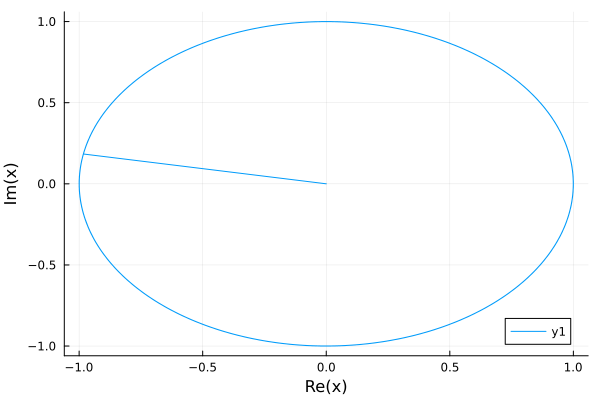

In [71]:
plot(uout[1,1,501,:])

In [47]:
s = uout[1,1,501,:];

In [ ]:
uref = phase_to_potential(0.0, tbase, 0.0, spk_args);

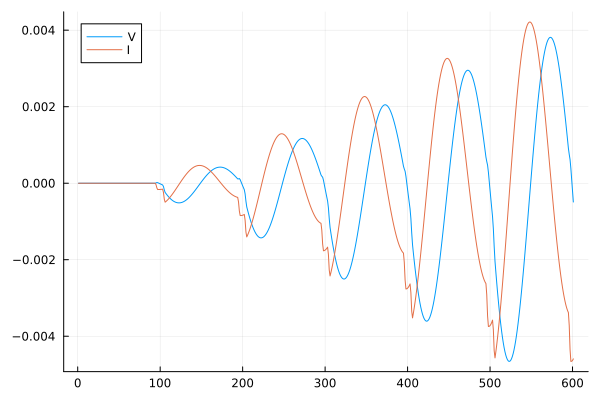

In [51]:
plot(imag.(s), label="V")
plot!(real.(s), label="I")

In [59]:
si = real.(s)
sv = imag.(s);

In [62]:
dffs = diff(sign.(si));

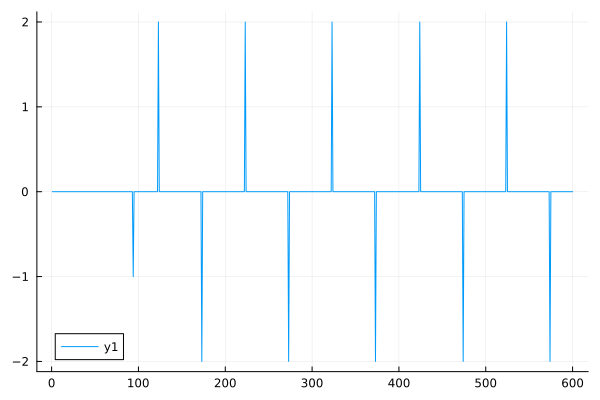

In [63]:
plot(dffs)

In [58]:
find_spikes_rf(s, tbase, spk_args)

(CartesianIndex(), Float64[])

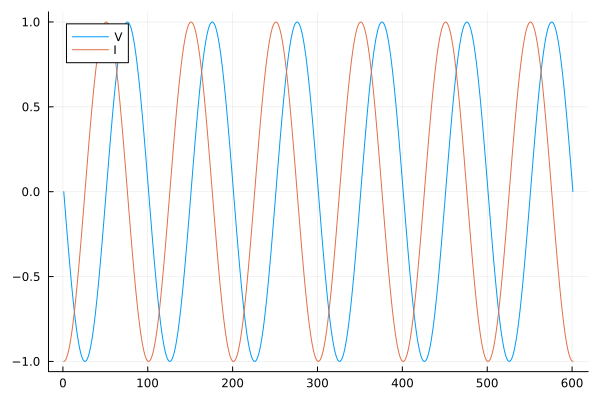

In [55]:
plot(imag.(uref), label="V")
plot!(real.(uref), label="I")

In [57]:
find_spikes_rf(uref, tbase, spk_args)

(CartesianIndex(), [0.75, 1.75, 2.74, 3.74, 4.74, 5.74])

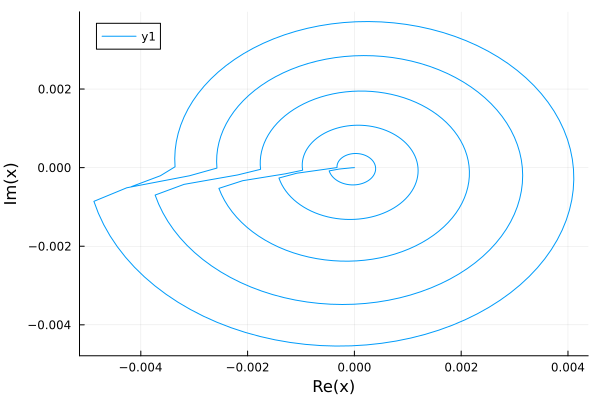

In [44]:
plot(uout[1,1,101,:])

In [36]:
spk_args.threshold

0.02

In [73]:
decoded = potential_to_phase(uout, tbase, dim=4, spk_args=spk_args) 

1×1×10201×601 Array{Float64, 4}:
[:, :, 1, 1] =
 -1.0

[:, :, 2, 1] =
 -1.0

[:, :, 3, 1] =
 -1.0

;;; … 

[:, :, 10199, 1] =
 -1.0

[:, :, 10200, 1] =
 -1.0

[:, :, 10201, 1] =
 -1.0

[:, :, 1, 2] =
 -2.7332060169693584e-5

[:, :, 2, 2] =
 0.019986333969915115

[:, :, 3, 2] =
 -0.9800000000000001

;;; … 

[:, :, 10199, 2] =
 -0.9800000000000001

[:, :, 10200, 2] =
 -0.9800000000000001

[:, :, 10201, 2] =
 -0.9800000000000001

[:, :, 1, 3] =
 -5.3700909575460365e-5

[:, :, 2, 3] =
 0.019959724939676793

[:, :, 3, 3] =
 0.03997314954521225

;;; … 

[:, :, 10199, 3] =
 -0.9600000000000001

[:, :, 10200, 3] =
 -0.9600000000000001

[:, :, 10201, 3] =
 -0.9600000000000001

;;;; … 

[:, :, 1, 599] =
 -0.03766360088588139

[:, :, 2, 599] =
 -0.01737595971753969

[:, :, 3, 599] =
 0.004104955842974878

;;; … 

[:, :, 10199, 599] =
 -0.07143327209811634

[:, :, 10200, 599] =
 -0.04393314971522022

[:, :, 10201, 599] =
 -0.038242779901573876

[:, :, 1, 600] =
 -0.037689967663198765

[:, :, 2, 60

In [74]:
decoded |> size

(1, 1, 10201, 601)

In [75]:
b[1,:,:] |> size

(1, 10201)

In [76]:
err = (decoded[1,:,:,:] .- b[1,:,:]);

In [77]:
err |> size

(1, 10201, 601)

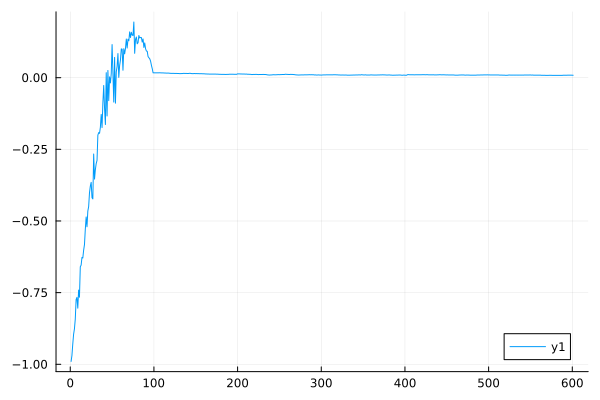

In [78]:
plot((mean(err, dims=2)) |> vec)

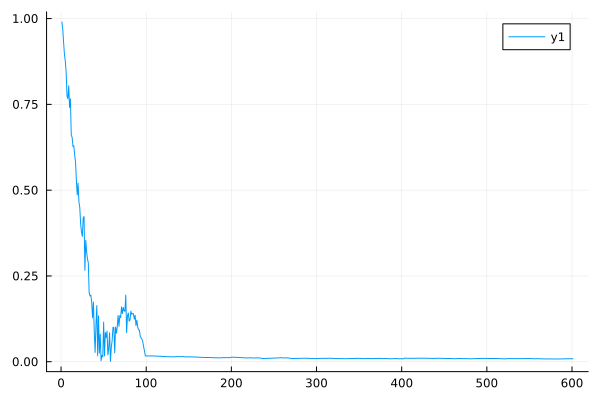

In [79]:
plot(abs.(mean(err, dims=2)) |> vec)

In [80]:
b2 = bind(st_x, st_y, tspan=tspan, return_solution=false);

In [81]:
b2.indices

54176-element Vector{CartesianIndex{3}}:
 CartesianIndex(1, 1, 2654)
 CartesianIndex(1, 1, 2754)
 CartesianIndex(1, 1, 2655)
 CartesianIndex(1, 1, 2755)
 CartesianIndex(1, 1, 2855)
 CartesianIndex(1, 1, 2656)
 CartesianIndex(1, 1, 2657)
 CartesianIndex(1, 1, 2756)
 CartesianIndex(1, 1, 2856)
 CartesianIndex(1, 1, 2956)
 ⋮
 CartesianIndex(1, 1, 9226)
 CartesianIndex(1, 1, 9327)
 CartesianIndex(1, 1, 9427)
 CartesianIndex(1, 1, 9527)
 CartesianIndex(1, 1, 9626)
 CartesianIndex(1, 1, 9727)
 CartesianIndex(1, 1, 9826)
 CartesianIndex(1, 1, 9827)
 CartesianIndex(1, 1, 10127)

In [82]:
b2d = train_to_phase(b2, spk_args)

6×1×1×10201 Array{Float64, 4}:
[:, :, 1, 1] =
 -0.020000000000000018
 -0.06000000000000005
 -0.05999999999999961
 -0.05999999999999961
 -0.0600000000000005
 -0.03999999999999915

[:, :, 1, 2] =
  0.0
 -0.040000000000000036
 -0.040000000000000036
 -0.040000000000000036
 -0.019999999999999574
 -0.019999999999999574

[:, :, 1, 3] =
  0.040000000000000036
  0.0
 -0.019999999999999574
 -0.019999999999999574
  0.0
  0.0

;;;; … 

[:, :, 1, 10199] =
 NaN
  -0.1200000000000001
  -0.1200000000000001
  -0.09999999999999964
  -0.09999999999999964
  -0.08000000000000007

[:, :, 1, 10200] =
 NaN
  -0.10000000000000009
  -0.09999999999999964
  -0.08000000000000007
  -0.0600000000000005
  -0.0600000000000005

[:, :, 1, 10201] =
 NaN
  -0.08000000000000007
  -0.08000000000000007
  -0.05999999999999961
  -0.0600000000000005
  -0.03999999999999915

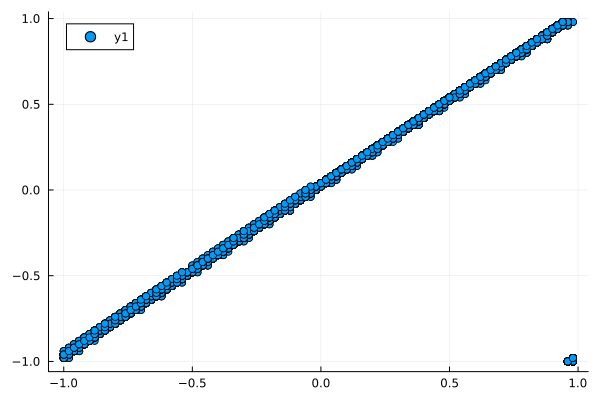

In [83]:
scatter(b2d[5,:,:,:] |> vec, b |> vec)